In [1]:
import re
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

In [47]:
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv')

In [48]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [49]:
df_fq['Week of grazing season'] = df_fq.groupby(
    ['Year', 'PastureID']).apply(
    lambda x: x['WOY'] + 1 - x['WOY'].min(), include_groups=False).reset_index(drop=True)

In [50]:
df_fq = df_fq.rename(columns={'Crude Protein (%)': 'CP',
                              'DOM(%)': 'DOM',
                              'Treatment': 'Treatment_full'})

In [51]:
df_fq['Treatment_full'].unique()

array(['CARM', 'TRM', 'CARM1', 'CARM2', 'Paired TRM1', 'Paired TRM2',
       'CARM77', 'CARM107'], dtype=object)

In [52]:
treatment_rename_dict = {
    'CARM1': 'CARM',
    'CARM2': 'CARM',
    'Paired TRM1': 'TRM',
    'Paired TRM2': 'TRM',
    'CARM77': 'CARM',
    'CARM107': 'CARM'
    
}

In [53]:
df_fq['Treatment'] = df_fq['Treatment_full'].apply(lambda x: treatment_rename_dict[x] if x in treatment_rename_dict.keys() else x)

In [54]:
df_fq['period'] = np.ceil(df_fq['Week of grazing season']/4).astype(int)

df_cp = df_fq[~df_fq['DOM'].isna()].copy()
df_cp = df_cp[df_cp['Treatment'] == 'TRM'].copy()
df_cp = df_cp[~df_cp['CP'].isna()].copy()

In [55]:
######
#df_cp = df_fq[df_fq['outlier'] != 1]  # remove suspected outliers
rand_st = 2313
cp_features = df_cp[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']]
# Saving feature names for later use
cp_feature_list = list(cp_features.columns)

df_cp['CP_grp'] = pd.qcut(df_cp['CP'], 5, labels=['low', 'modlow', 'avg', 'modhi', 'hi'])
CP_skf = StratifiedKFold(n_splits=10, random_state=rand_st, shuffle=True)
#CP_skf = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=rand_st)
CP_skf_cv = CP_skf.split(cp_features, df_cp['period'])

cp_labels = df_cp['CP']

In [56]:
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}
param_grid = {
    'RF__min_samples_split': [0.001, 0.01, 0.10],
    'RF__n_estimators': [100, 250, 500, 750],
    'RF__max_samples': [0.1, 0.25, 0.5, 0.75, 0.90],
    'RF__max_features': [2, 3, 4, 5],
}

CP_skf = StratifiedKFold(n_splits=10, random_state=rand_st, shuffle=True)
CP_skf_cv = CP_skf.split(cp_features, df_cp['period'])

# Create a based model
rf_cp_r2 = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_jobs=1))
                ])
# Instantiate the grid search model
cp_grid_search = GridSearchCV(estimator=rf_cp_r2, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=CP_skf_cv, n_jobs=-1, verbose=0)

# Fit the grid search to the data
cp_grid_search.fit(cp_features, cp_labels)
results = cp_grid_search.cv_results_

In [57]:
cp_grid_search.best_params_

{'RF__max_features': 2,
 'RF__max_samples': 0.75,
 'RF__min_samples_split': 0.001,
 'RF__n_estimators': 500}

In [58]:
print('R^2-CV: ' + str(results['mean_test_R2'][results['rank_test_MSE'] == 1]))
print('R^2-CV std: ' + str(results['std_test_R2'][results['rank_test_MSE'] == 1]))
print('MSE-CV: ' + str(-1.0 * results['mean_test_MSE'][results['rank_test_MSE'] == 1]))
print('MSE-CV std: ' + str(results['std_test_MSE'][results['rank_test_MSE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 1] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 1] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.74237134]
R^2-CV std: [0.0809659]
MSE-CV: [1.29357912]
MSE-CV std: [0.36757899]
RMSE-CV: 0.5953989146064117
RMSE-CV std: 0.010122304246301334


In [59]:
df_results = pd.DataFrame({k:results[k] for k in results.keys() if not k.startswith('split')})

In [60]:
df_results.loc[df_results['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'

In [61]:
df_results['param_RF__max_samples'] = df_results['param_RF__max_samples'].astype(str)

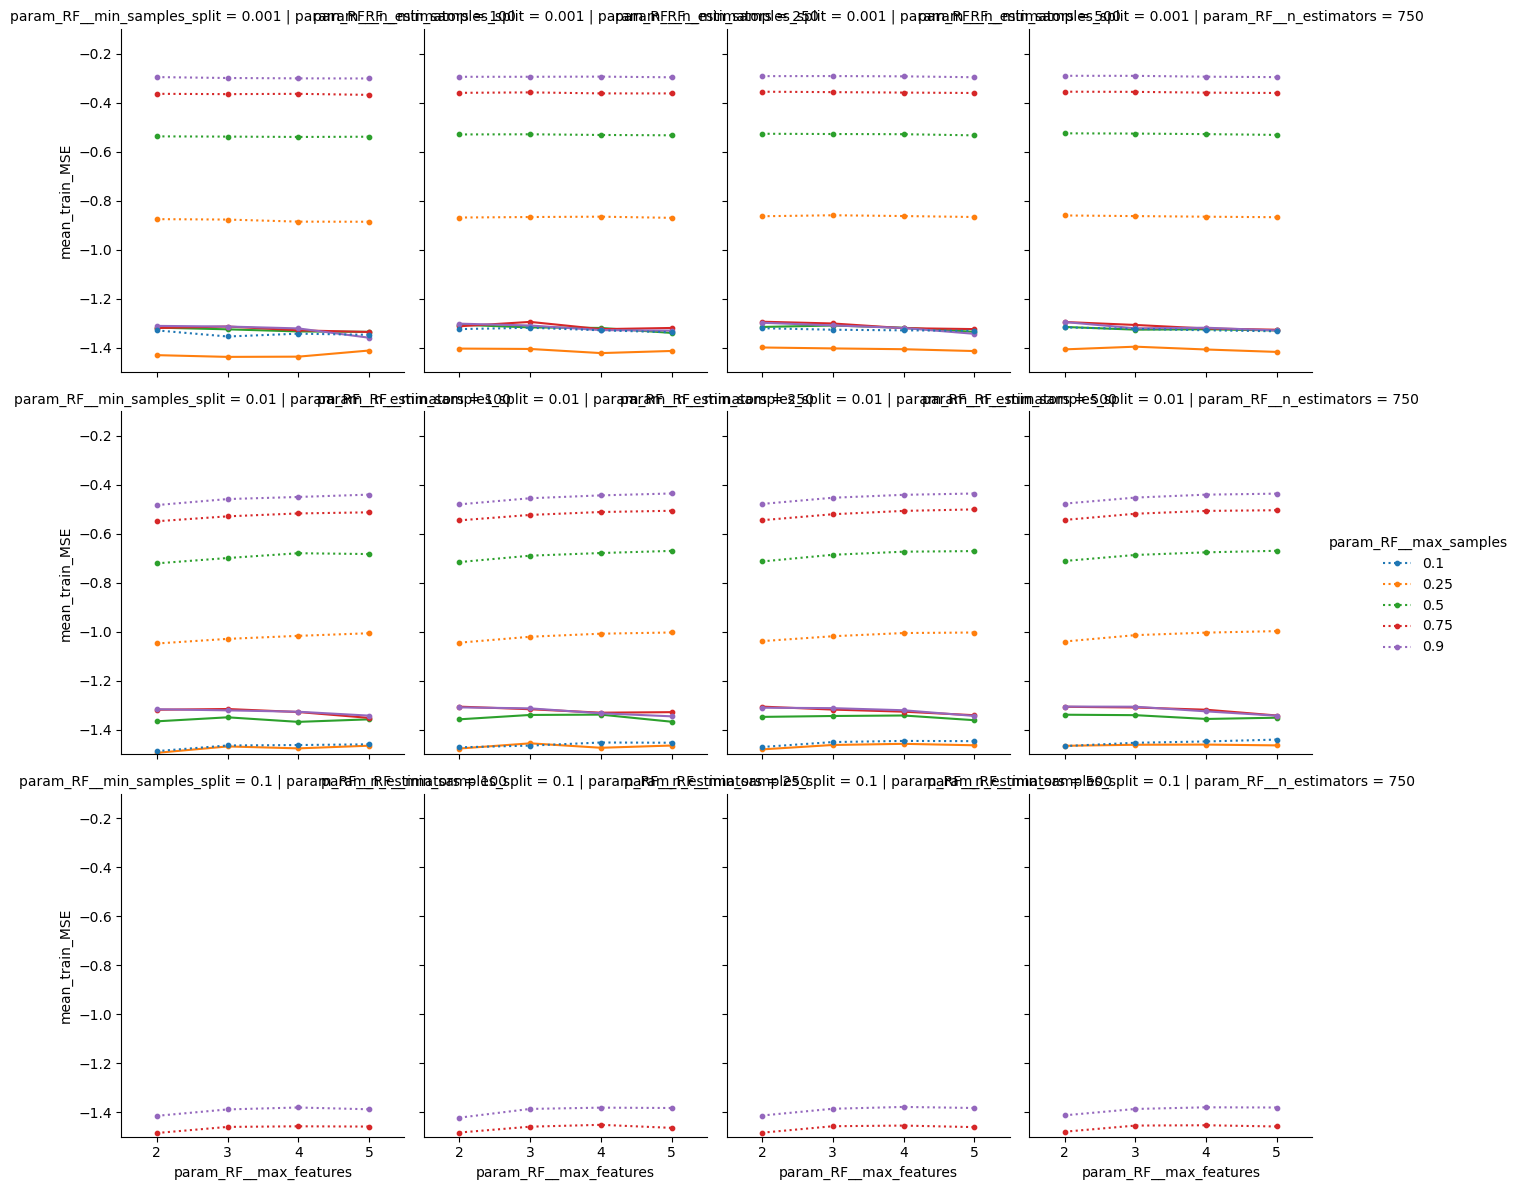

In [62]:
p = sns.FacetGrid(data=df_results,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((-1.5, -0.1))
p.add_legend()

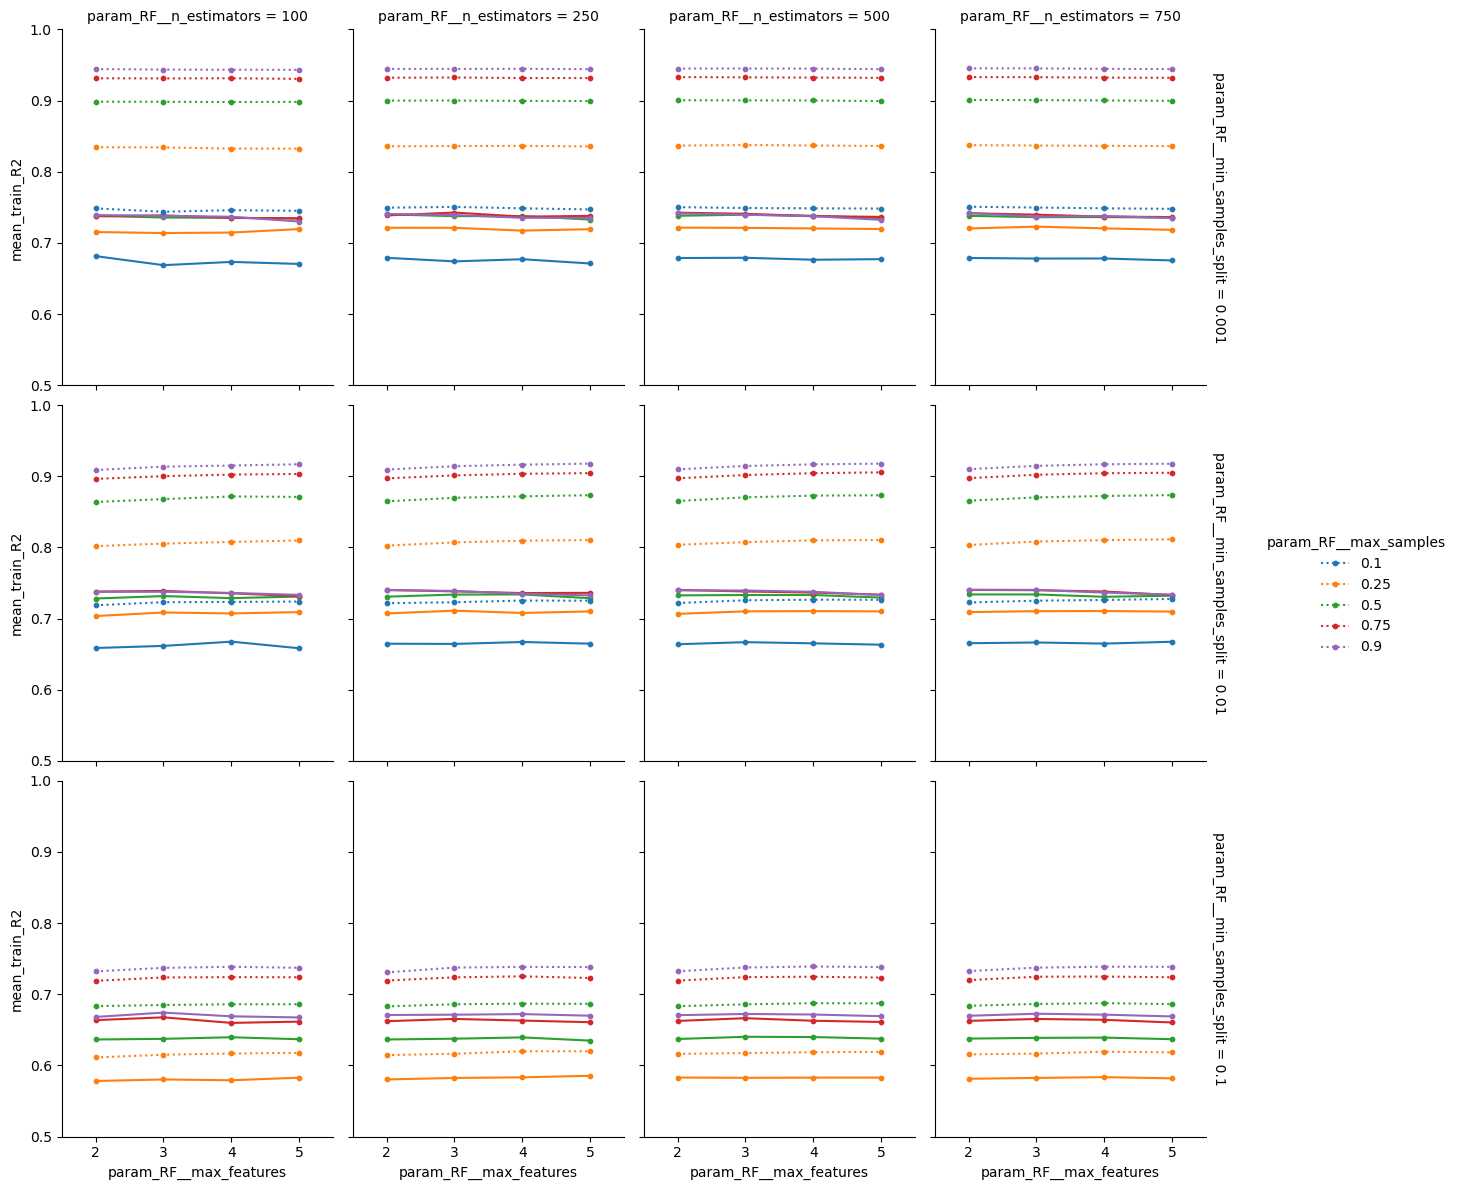

In [63]:
p = sns.FacetGrid(data=df_results,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((0.5, 1.0))
p.add_legend()

In [64]:
max_features = 3
n_estimators = 250
min_samples_split = 0.001
max_samples = 0.75
best_result_manual = df_results[(df_results['param_RF__max_features'] == max_features) &
(df_results['param_RF__n_estimators'] == n_estimators) &
(df_results['param_RF__min_samples_split'] == min_samples_split) &
(df_results['param_RF__max_samples'] == str(max_samples))]
display(best_result_manual.drop(columns=['params']))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF__max_features,param_RF__max_samples,param_RF__min_samples_split,param_RF__n_estimators,mean_test_R2,std_test_R2,rank_test_R2,mean_train_R2,std_train_R2,mean_test_MSE,std_test_MSE,rank_test_MSE,mean_train_MSE,std_train_MSE
97,0.519666,0.010115,0.013485,0.00093,3,0.75,0.001,250,0.742538,0.080788,1,0.932344,0.002512,-1.294283,0.373032,2,-0.357403,0.012709


In [70]:
print('R^2-CV: ' + str(results['mean_test_R2'][results['rank_test_MSE'] == 2]))
print('R^2-CV std: ' + str(results['std_test_R2'][results['rank_test_MSE'] == 2]))
print('MSE-CV: ' + str(-1.0 * results['mean_test_MSE'][results['rank_test_MSE'] == 2]))
print('MSE-CV std: ' + str(results['std_test_MSE'][results['rank_test_MSE'] == 2]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 2] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 2] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.74253791]
R^2-CV std: [0.08078806]
MSE-CV: [1.29428254]
MSE-CV std: [0.37303249]
RMSE-CV: 0.5977370509327949
RMSE-CV std: 0.010663527451842153


In [66]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=n_estimators,
                                                 max_features=max_features, 
                                                 min_samples_split=min_samples_split, 
                                                 max_samples=max_samples,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(cp_features, cp_labels)

# Use the forest's predict method on the test data
pred_cp = rf_cp_fnl.predict(cp_features)
# Calculate the absolute errors_cp
errors_cp = np.mean((pred_cp - cp_labels)**2)
# Print out the mean absolute error (mae)
print('RMSE:', round(np.sqrt(np.mean(errors_cp)), 2))
#plt.figure()
#plt.scatter(pred_cp, cp_labels)
#abline(1, 0)

RMSE: 0.6


In [67]:
df_cp['CP_pred'] = pred_cp
df_fq['CP_pred'] = rf_cp_fnl.predict(df_fq[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']])

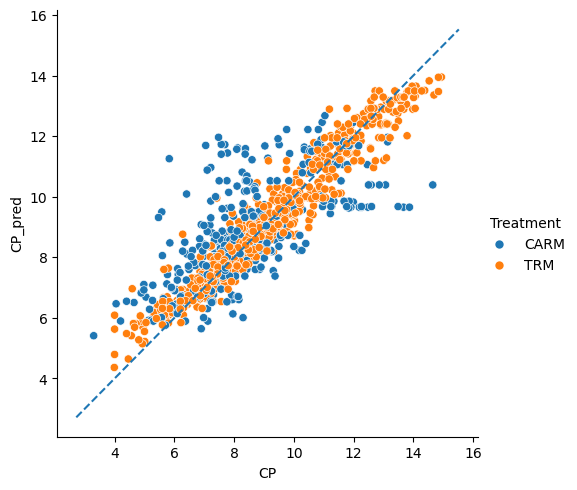

In [68]:
p = sns.relplot(x='CP', y='CP_pred', hue='Treatment', data=df_fq)
abline(1, 0)

In [69]:
import pickle
pickle.dump(rf_cp_fnl, open('../models/diet_quality/rf_cp_ndvi_2014_2023.pkl', 'wb'))

In [71]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

In [72]:
########################################################
cp_levels = np.arange(6.5, 12.5, 0.5)
cp_grid_res = 20
cp_percentiles = [0, 1]
cp_lines = True
cp_labels = False
fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], wspace=0.20)
gs_leg = mpl.gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.3], top=0.85, bottom=0.10)

<Figure size 1000x1000 with 0 Axes>

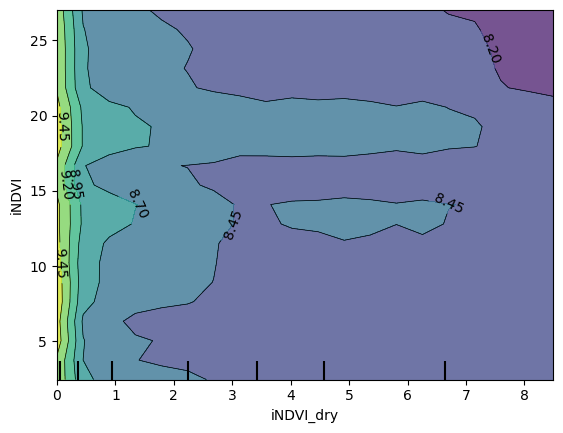

In [74]:
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                               cp_features,
                                               [(4, 2)], 
                                               grid_resolution=cp_grid_res,
                                               #percentiles=(0,1), 
                                               #contour_kw={'levels': cp_levels},
                                               n_jobs=-1)

In [75]:
ax1 = fig.add_subplot(gs[0, 0])
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(4, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax1,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax2 = fig.add_subplot(gs[0, 1])
pdp2 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax2,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp2.axes_[0][0].set_xlabel('')
pdp2.axes_[0][0].set_ylabel('')

ax3 = fig.add_subplot(gs[0, 2])
pdp3 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax3,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp3.axes_[0][0].set_xlabel('')
pdp3.axes_[0][0].set_ylabel('')

ax4 = fig.add_subplot(gs[0, 3])
pdp4 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax4,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp4.axes_[0][0].set_xlabel('')
pdp4.axes_[0][0].set_ylabel('')

ax5 = fig.add_subplot(gs[1, 1])
pdp5 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax5,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax6 = fig.add_subplot(gs[1, 2])
pdp6 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax6,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp6.axes_[0][0].set_xlabel('')
pdp6.axes_[0][0].set_ylabel('')

ax7 = fig.add_subplot(gs[1, 3])
pdp7 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax7,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp7.axes_[0][0].set_xlabel('')
pdp7.axes_[0][0].set_ylabel('')

ax8 = fig.add_subplot(gs[2, 2])
pdp8 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax8,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax9 = fig.add_subplot(gs[2, 3])
pdp9 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax9,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp9.axes_[0][0].set_xlabel('')
pdp9.axes_[0][0].set_ylabel('')

ax10 = fig.add_subplot(gs[3, 3])
pdp10 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 3)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax10,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

norm = mpl.colors.Normalize(vmin=6, vmax=12)
cm = plt.get_cmap('viridis')
ax_leg = plt.axes([0.05, 0.13, 0.5, 0.05])
ax_leg.set_title('CP (%)', fontsize=20, pad=25, loc='center')
bounds = np.arange(6, 12.5, 0.5)

cb1 = mpl.colorbar.ColorbarBase(ax_leg, cmap=cm,
                                norm=norm, spacing='proportional', boundaries=bounds,
                                orientation='horizontal')
ax_leg.tick_params(axis='both', labelsize=18)

for ax_i in [pdp1, pdp2, pdp3, pdp4, pdp5, pdp6, pdp7, pdp8, pdp9, pdp10]:
    ax_i.axes_[0][0].yaxis.label.set_size(14)
    ax_i.axes_[0][0].xaxis.label.set_size(14)
    ax_i.axes_[0][0].tick_params(axis='both',  labelsize=14)

gs.tight_layout(fig, w_pad=0, h_pad=0)
gs.update(wspace=0.30)
#gs_leg.tight_layout(fig, w_pad=0, h_pad=0)
#gs_leg.update(top=0.90, bottom=0.10, left=0.40)

TypeError: from_estimator() got an unexpected keyword argument 'levels'